In [ ]:
'''
Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
'''
### Run the following command to install required packages:
#! pip install -r requirements.txt

In [ ]:
import os
import glob
import cv2
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
import csv
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import keras.backend as K 
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras.applications import DenseNet121

from sklearn.metrics import roc_auc_score

import glob
import gc
import shutil
from joblib import Parallel, delayed
import multiprocessing
import librosa
import librosa.display
from matplotlib import pyplot

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [2]:
current_dir = "./blue_whales/"

data_dir = current_dir + "data/"
labeled_data_dir = data_dir + 'labeled_data/'
spectrogram_dir = data_dir + "extracted_spectrogram/"


In [3]:
directory_filenames_ANT_Positive = glob.glob(spectrogram_dir + 'ANT_Positive_*.png')
directory_filenames_AUS_Positive = glob.glob(spectrogram_dir + 'AUS_Positive_*.png')
directory_filenames_MAD_Positive = glob.glob(spectrogram_dir + 'MAD_Positive_*.png')
directory_filenames_SRI_Positive = glob.glob(spectrogram_dir + 'SRI_Positive_*.png')

directory_filenames_ANT_Negative = glob.glob(spectrogram_dir + 'ANT_Negative_*.png')
directory_filenames_AUS_Negative = glob.glob(spectrogram_dir + 'AUS_Negative_*.png')
directory_filenames_MAD_Negative = glob.glob(spectrogram_dir + 'MAD_Negative_*.png')
directory_filenames_SRI_Negative = glob.glob(spectrogram_dir + 'SRI_Negative_*.png')

print("Number of spectrograms (ANT - with call):", len(directory_filenames_ANT_Positive))
print("Number of spectrograms (AUS - with call):", len(directory_filenames_AUS_Positive))
print("Number of spectrograms (MAD - with call):", len(directory_filenames_MAD_Positive))
print("Number of spectrograms (SRI - with call):", len(directory_filenames_SRI_Positive))

print("Number of spectrograms (ANT - without call):", len(directory_filenames_ANT_Negative))
print("Number of spectrograms (AUS - without call):", len(directory_filenames_AUS_Negative))
print("Number of spectrograms (MAD - without call):", len(directory_filenames_MAD_Negative))
print("Number of spectrograms (SRI - without call):", len(directory_filenames_SRI_Negative))

Number of spectrograms (ANT - with call): 1491
Number of spectrograms (AUS - with call): 1459
Number of spectrograms (MAD - with call): 2670
Number of spectrograms (SRI - with call): 659
Number of spectrograms (ANT - without call): 1099
Number of spectrograms (AUS - without call): 1988
Number of spectrograms (MAD - without call): 1187
Number of spectrograms (SRI - without call): 1602


In [4]:
directory_filenames_Positive = directory_filenames_ANT_Positive + directory_filenames_AUS_Positive + directory_filenames_MAD_Positive + directory_filenames_SRI_Positive
labels_Positive = ['ANT'] * len(directory_filenames_ANT_Positive) + ['AUS'] * len(directory_filenames_AUS_Positive) + ['MAD'] * len(directory_filenames_MAD_Positive) + ['SRI'] * len(directory_filenames_SRI_Positive)

directory_filenames_Negative = directory_filenames_ANT_Negative + directory_filenames_AUS_Negative + directory_filenames_MAD_Negative + directory_filenames_SRI_Negative
labels_Negative = ['ANT'] * len(directory_filenames_ANT_Negative) + ['AUS'] * len(directory_filenames_AUS_Negative) + ['MAD'] * len(directory_filenames_MAD_Negative) + ['SRI'] * len(directory_filenames_SRI_Negative)


In [5]:
lb = LabelBinarizer()
labels_Positive = lb.fit_transform(labels_Positive)
labels_Positive = labels_Positive.astype('float')

labels_Negative = lb.fit_transform(labels_Negative)
labels_Negative = labels_Negative.astype('float')
labels_Negative[labels_Negative == 0] = np.nan  
labels_Negative[labels_Negative == 1] = 0 

number_of_classes = len(lb.classes_)
print("Number of Species: ", number_of_classes)

species_id_class_dict = dict()
for (class_label, species_id) in enumerate(lb.classes_):
    species_id_class_dict[species_id] = class_label
    print("species_id ", species_id, ": ", class_label)



Number of Species:  4
species_id  ANT :  0
species_id  AUS :  1
species_id  MAD :  2
species_id  SRI :  3


In [ ]:
spectrograms_Positive = []
ncol, nrow = 224, 224

for i in range(len(directory_filenames_Positive)):
    img = cv2.imread(directory_filenames_Positive[i])  
    img = cv2.resize(img, (ncol, nrow)) / 255.0
    spectrograms_Positive.append(img)

spectrograms_Positive = np.asarray(spectrograms_Positive)


In [ ]:
spectrograms_Negative = []
ncol, nrow = 224, 224

for i in range(len(directory_filenames_Negative)):
    img = cv2.imread(directory_filenames_Negative[i])  
    img = cv2.resize(img, (ncol, nrow)) / 255.0
    spectrograms_Negative.append(img)

spectrograms_Negative = np.asarray(spectrograms_Negative)

In [8]:
X_train_validation_Positive, X_test_Positive, y_train_validation_Positive, y_test_Positive, directory_filenames_Positive_train_validation, directory_filenames_Positive_test = train_test_split(spectrograms_Positive, labels_Positive, directory_filenames_Positive, test_size = 0.3, random_state = 42)
X_train_validation_Negative, X_test_Negative, y_train_validation_Negative, y_test_Negative, directory_filenames_Negative_train_validation, directory_filenames_Negative_test = train_test_split(spectrograms_Negative, labels_Negative, directory_filenames_Negative, test_size = 0.3, random_state = 42)


In [9]:
X_train_validation = np.concatenate([X_train_validation_Positive, X_train_validation_Negative])
del X_train_validation_Positive
del X_train_validation_Negative

y_train_validation = np.concatenate([y_train_validation_Positive, y_train_validation_Negative])
del y_train_validation_Positive
del y_train_validation_Negative

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size = 0.3, random_state = 42)

print(X_train.shape)   
print(y_train.shape)
print(X_validation.shape)   
print(y_validation.shape)
print(X_test_Positive.shape)   
print(y_test_Positive.shape)
print(X_test_Negative.shape)   
print(y_test_Negative.shape)


(5955, 224, 224, 3)
(5955, 4)
(2553, 224, 224, 3)
(2553, 4)
(1884, 224, 224, 3)
(1884, 4)
(1763, 224, 224, 3)
(1763, 4)


In [10]:
def missing_values_cross_entropy_loss(y_true, y_pred):
    epsilon = 1.0e-30

    y_true_not_nan_mask = tf.logical_not(tf.math.is_nan(y_true))
    y_true_nan_replaced = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)

    positive_predictions_cross_entropy = y_true_nan_replaced * tf.math.log(y_pred + epsilon)
    negative_predictions_cross_entropy = (1.0 - y_true_nan_replaced) * tf.math.log(1.0 - y_pred + epsilon)
    cross_entropy_loss = -(positive_predictions_cross_entropy + negative_predictions_cross_entropy)

    cross_entropy_loss_discarded_nan_labels = cross_entropy_loss * tf.cast(y_true_not_nan_mask, tf.float32)

    mean_loss_per_row = K.mean(cross_entropy_loss_discarded_nan_labels, axis=1)
    mean_loss = K.mean(mean_loss_per_row)

    return mean_loss

In [11]:
number_of_classes = y_train.shape[1]

DenseNet121_conv = DenseNet121(weights='imagenet', include_top=False, input_shape=(nrow, ncol, 3))

for layer in DenseNet121_conv.layers:
    layer.trainable = True

for layer in DenseNet121_conv.layers:
    print(layer, layer.trainable)

model = models.Sequential()
model.add(DenseNet121_conv)

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(number_of_classes, activation='sigmoid'))
optimizer = optimizers.adam(lr=0.0001, decay=1e-7)
model.compile(loss = missing_values_cross_entropy_loss, optimizer = optimizer, metrics = ['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
<keras.engine.input_layer.InputLayer object at 0x00000216D30825F8> True
<keras.layers.convolutional.ZeroPadding2D object at 0x00000216D3082B70> True
<keras.layers.convolutional.Conv2D object at 0x00000216D3082978> True
<keras.layers.normalization.BatchNormalization object at 0x00000216D3082DA0> True
<keras.layers.core.Activation object at 0x00000216D2FA3A90> True
<keras.layers.convolutional.ZeroPadding2D object at 0x00000216D3112898> True
<keras.layers.pooling.MaxPooling2D object at 0x00000216D31C0CC0> True
<keras.layers.normalization.BatchNormalization object at 0x00000216D3171D30> True
<keras.layers.core.Activation object at 0x00000216D33C5748> True
<keras.layers.convolutional.Conv2D object at 0x00000216D3430F98> True
<keras.layers.normalization.BatchNormalization object at 0x00000216D3410BA8> True
<keras.layers.core.Activation object at 0x00000216D345EFD0> True
<keras.layers.convolutional.Conv2D object at 0x0000

Instructions for updating:
Use tf.cast instead.
Train on 5955 samples, validate on 2553 samples
Epoch 1/5
5955/5955 [==============================] - 8471s 1s/step - loss: 0.2447 - acc: 0.6166 - val_loss: 0.0965 - val_acc: 0.7681
Epoch 2/5
5955/5955 [==============================] - 6903s 1s/step - loss: 0.1069 - acc: 0.6935 - val_loss: 0.0778 - val_acc: 0.7395
Epoch 3/5
5955/5955 [==============================] - 6894s 1s/step - loss: 0.0748 - acc: 0.6917 - val_loss: 0.0738 - val_acc: 0.7195
Epoch 4/5
5955/5955 [==============================] - 6888s 1s/step - loss: 0.0557 - acc: 0.6846 - val_loss: 0.0713 - val_acc: 0.7309
Epoch 5/5
5955/5955 [==============================] - 6895s 1s/step - loss: 0.0456 - acc: 0.6831 - val_loss: 0.0900 - val_acc: 0.6874


Text(0.5, 1.0, 'Predicted Probability - SRI')

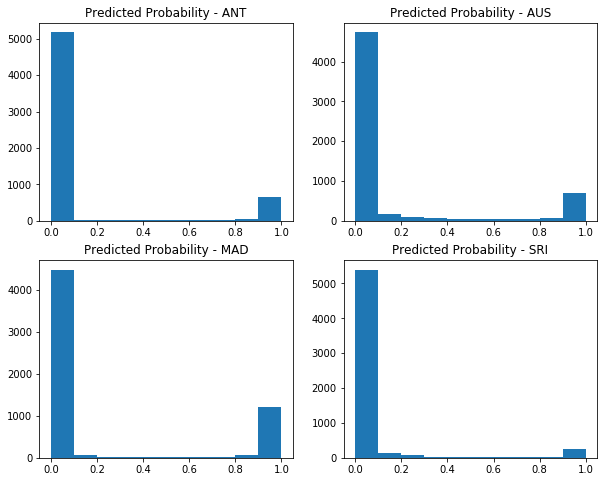

In [12]:
model_history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_validation, y_validation))
y_train_pred_prob = model.predict(X_train)

    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 8))
ax = ax.ravel() 

ax[0].hist(y_train_pred_prob[:,0])
ax[0].set_title('Predicted Probability - ANT')

ax[1].hist(y_train_pred_prob[:,1])
ax[1].set_title('Predicted Probability - AUS')

ax[2].hist(y_train_pred_prob[:,2])
ax[2].set_title('Predicted Probability - MAD')

ax[3].hist(y_train_pred_prob[:,3])
ax[3].set_title('Predicted Probability - SRI')

# Prediction for labeled calls (all positive)

In [15]:
yhat_probs_Positive = model.predict(spectrograms_Positive)

yhat_positive_probs_ANT = yhat_probs_Positive[:,0]
yhat_positive_probs_AUS = yhat_probs_Positive[:,1]
yhat_positive_probs_MAD = yhat_probs_Positive[:,2]
yhat_positive_probs_SRI = yhat_probs_Positive[:,3]

print('number of predicted ANT calls:', sum([x>=0.5 for x in yhat_positive_probs_ANT]))
print('number of predicted AUS calls:', sum([x>=0.5 for x in yhat_positive_probs_AUS]))
print('number of predicted MAD calls:', sum([x>=0.5 for x in yhat_positive_probs_MAD]))
print('number of predicted SRI calls:', sum([x>=0.5 for x in yhat_positive_probs_SRI]))

number of predicted ANT calls: 1396
number of predicted AUS calls: 1374
number of predicted MAD calls: 2516
number of predicted SRI calls: 561


Text(0.5, 1.0, 'Predicted Probability - SRI')

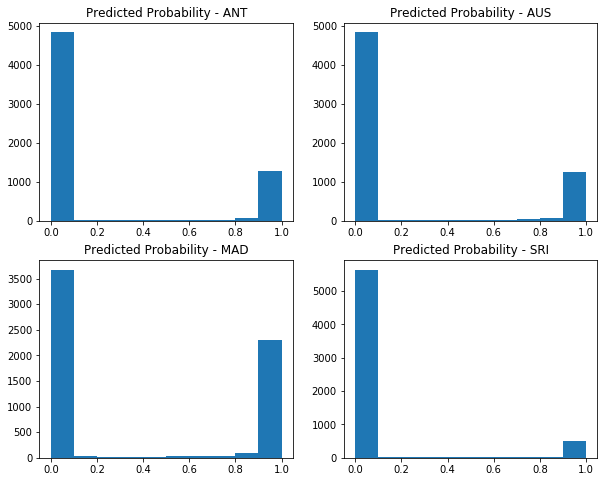

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 8))
ax = ax.ravel() 

ax[0].hist(yhat_positive_probs_ANT)
ax[0].set_title('Predicted Probability - ANT')

ax[1].hist(yhat_positive_probs_AUS)
ax[1].set_title('Predicted Probability - AUS')

ax[2].hist(yhat_positive_probs_MAD)
ax[2].set_title('Predicted Probability - MAD')

ax[3].hist(yhat_positive_probs_SRI)
ax[3].set_title('Predicted Probability - SRI')

# Prediction for spectrograms extracted from "nocall" clips

Text(0.5, 1.0, 'Predicted Probability - Not SRI')

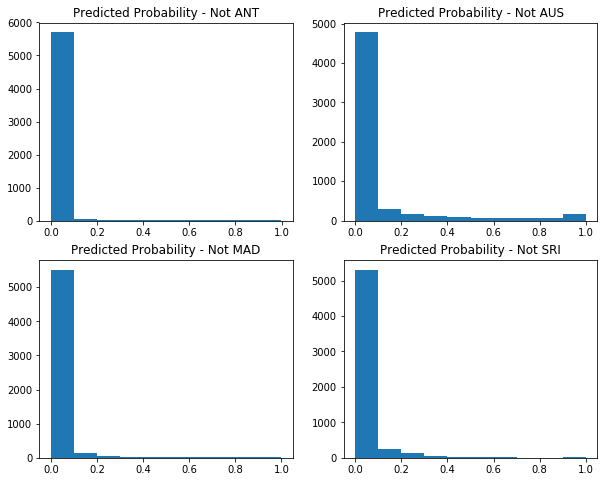

In [17]:
yhat_probs_Negative = model.predict(spectrograms_Negative)

yhat_Negative_probs_ANT = yhat_probs_Negative[:,0]
yhat_Negative_probs_AUS = yhat_probs_Negative[:,1]
yhat_Negative_probs_MAD = yhat_probs_Negative[:,2]
yhat_Negative_probs_SRI = yhat_probs_Negative[:,3]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 8))
ax = ax.ravel() 

ax[0].hist(yhat_Negative_probs_ANT)
ax[0].set_title('Predicted Probability - Not ANT')

ax[1].hist(yhat_Negative_probs_AUS)
ax[1].set_title('Predicted Probability - Not AUS')

ax[2].hist(yhat_Negative_probs_MAD)
ax[2].set_title('Predicted Probability - Not MAD')

ax[3].hist(yhat_Negative_probs_SRI)
ax[3].set_title('Predicted Probability - Not SRI')

# Model Evaluation on Test set

In [18]:
yhat_probs_Positive_test = model.predict(X_test_Positive)

yhat_Positive_test_probs_ANT = yhat_probs_Positive_test[:,0]
yhat_Positive_test_probs_AUS = yhat_probs_Positive_test[:,1]
yhat_Positive_test_probs_MAD = yhat_probs_Positive_test[:,2]
yhat_Positive_test_probs_SRI = yhat_probs_Positive_test[:,3]

yhat_probs_Negative_test = model.predict(X_test_Negative)

yhat_Negative_test_probs_ANT = yhat_probs_Negative_test[:,0]
yhat_Negative_test_probs_AUS = yhat_probs_Negative_test[:,1]
yhat_Negative_test_probs_MAD = yhat_probs_Negative_test[:,2]
yhat_Negative_test_probs_SRI = yhat_probs_Negative_test[:,3]


In [19]:
output_positive_test = pd.DataFrame()
output_positive_test['filename'] = directory_filenames_Positive_test
output_positive_test['label'] = 1
output_positive_test['predicted_probability'] = 0.0
for i in range(len(output_positive_test)):
    species_id = output_positive_test.loc[i, 'filename'].split('\\')[-1].split('_')[0]
    predicted_probability = yhat_probs_Positive_test[i][species_id_class_dict[species_id]]
    output_positive_test.at[i, 'species_id'] = species_id
    output_positive_test.at[i, 'predicted_probability'] = predicted_probability
    
output_negative_test = pd.DataFrame()
output_negative_test['filename'] = directory_filenames_Negative_test
output_negative_test['label'] = 0
output_negative_test['predicted_probability'] = 0.0
for i in range(len(output_negative_test)):
    species_id = output_negative_test.loc[i, 'filename'].split('\\')[-1].split('_')[0]
    predicted_probability = yhat_probs_Negative_test[i][species_id_class_dict[species_id]]
    output_negative_test.at[i, 'species_id'] = species_id
    output_negative_test.at[i, 'predicted_probability'] = predicted_probability  


Text(0.5, 1.0, 'Predicted Probability - Without Blue Whale Calls')

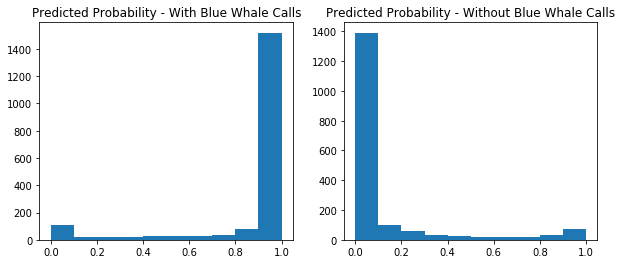

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax = ax.ravel() 

ax[0].hist(output_positive_test.predicted_probability)
ax[0].set_title('Predicted Probability - With Blue Whale Calls')

ax[1].hist(output_negative_test.predicted_probability)
ax[1].set_title('Predicted Probability - Without Blue Whale Calls')

No handles with labels found to put in legend.


False Negative Rate: 10.72%
False Positive Rate: 9.08%
AUC: 0.9565
Accuracy: 0.9007
Precision: 0.9131
Recall: 0.8928


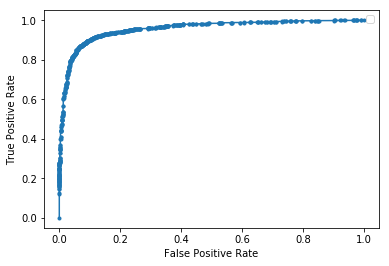

No handles with labels found to put in legend.


Precesion Recall AUC: 0.9622


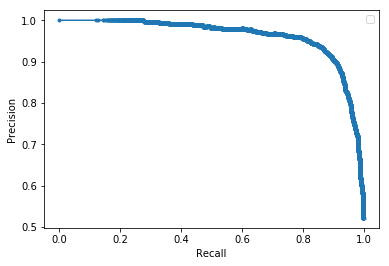

In [21]:
tp = len([i for i,v in enumerate(output_positive_test.predicted_probability) if v >= 0.5])
fn = len([i for i,v in enumerate(output_positive_test.predicted_probability) if v < 0.5])
tn = len([i for i,v in enumerate(output_negative_test.predicted_probability) if v < 0.5])
fp = len([i for i,v in enumerate(output_negative_test.predicted_probability) if v >= 0.5])
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

y_true_test = output_positive_test.label.tolist()+ output_negative_test.label.tolist()
y_predicted_probability_test = output_positive_test.predicted_probability.tolist() + output_negative_test.predicted_probability.tolist()
AUC = roc_auc_score(y_true_test, y_predicted_probability_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

fpr, tpr, thresholds = roc_curve(y_true_test, y_predicted_probability_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true_test, y_predicted_probability_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Evaluation for ANT

Text(0.5, 1.0, 'Predicted Probability - Without ANT Calls')

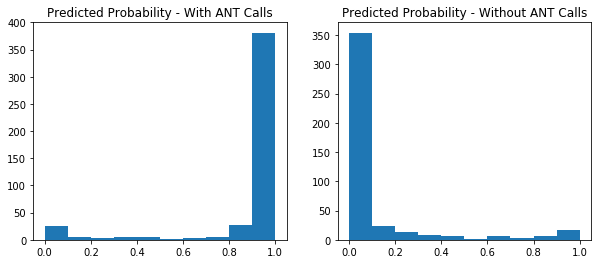

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax = ax.ravel() 

ax[0].hist(output_positive_test.loc[output_positive_test.species_id =='ANT'].predicted_probability)
ax[0].set_title('Predicted Probability - With ANT Calls')

ax[1].hist(output_negative_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability)
ax[1].set_title('Predicted Probability - Without ANT Calls')


No handles with labels found to put in legend.


False Negative Rate: 10.04%
False Positive Rate: 7.76%
AUC: 0.9491
Accuracy: 0.9106
Precision: 0.9253
Recall: 0.8996


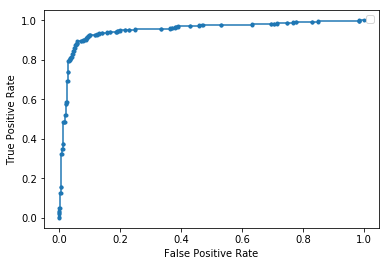

No handles with labels found to put in legend.


Precesion Recall AUC: 0.9496


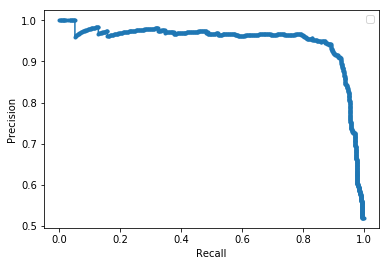

In [23]:
tp = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability) if v >= 0.5])
fn = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability) if v < 0.5])
tn = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability) if v < 0.5])
fp = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability) if v >= 0.5])
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

y_true_test = output_positive_test.loc[output_positive_test.species_id  =='ANT'].label.tolist()+ output_negative_test.loc[output_positive_test.species_id  =='ANT'].label.tolist()
y_predicted_probability_test = output_positive_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability.tolist() + output_negative_test.loc[output_positive_test.species_id  =='ANT'].predicted_probability.tolist()
AUC = roc_auc_score(y_true_test, y_predicted_probability_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

fpr, tpr, thresholds = roc_curve(y_true_test, y_predicted_probability_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true_test, y_predicted_probability_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Evaluation for AUS

Text(0.5, 1.0, 'Predicted Probability - Without AUS Calls')

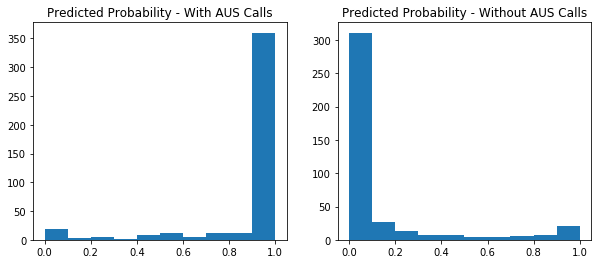

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax = ax.ravel() 

ax[0].hist(output_positive_test.loc[output_positive_test.species_id =='AUS'].predicted_probability)
ax[0].set_title('Predicted Probability - With AUS Calls')

ax[1].hist(output_negative_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability)
ax[1].set_title('Predicted Probability - Without AUS Calls')

No handles with labels found to put in legend.


False Negative Rate: 8.29%
False Positive Rate: 10.12%
AUC: 0.9602
Accuracy: 0.9082
Precision: 0.9066
Recall: 0.9171


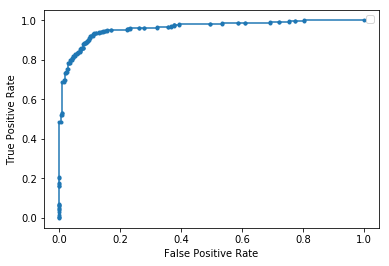

No handles with labels found to put in legend.


Precesion Recall AUC: 0.9673


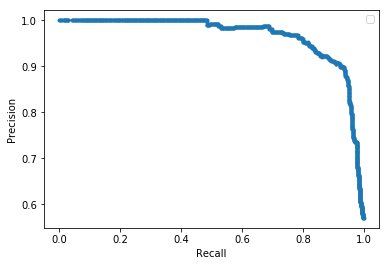

In [25]:
tp = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability) if v >= 0.5])
fn = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability) if v < 0.5])
tn = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability) if v < 0.5])
fp = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability) if v >= 0.5])
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

y_true_test = output_positive_test.loc[output_positive_test.species_id  =='AUS'].label.tolist()+ output_negative_test.loc[output_positive_test.species_id  =='AUS'].label.tolist()
y_predicted_probability_test = output_positive_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability.tolist() + output_negative_test.loc[output_positive_test.species_id  =='AUS'].predicted_probability.tolist()
AUC = roc_auc_score(y_true_test, y_predicted_probability_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

fpr, tpr, thresholds = roc_curve(y_true_test, y_predicted_probability_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true_test, y_predicted_probability_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Evaluation for MAD

Text(0.5, 1.0, 'Predicted Probability - Without MAD Calls')

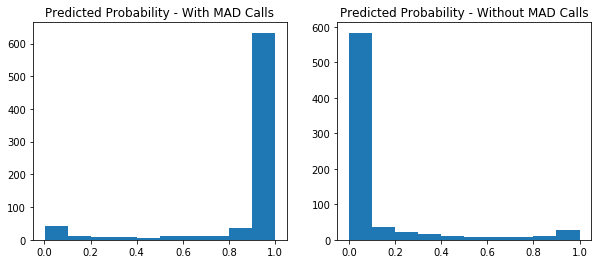

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax = ax.ravel() 

ax[0].hist(output_positive_test.loc[output_positive_test.species_id =='MAD'].predicted_probability)
ax[0].set_title('Predicted Probability - With MAD Calls')

ax[1].hist(output_negative_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability)
ax[1].set_title('Predicted Probability - Without MAD Calls')


No handles with labels found to put in legend.


False Negative Rate: 9.51%
False Positive Rate: 9.02%
AUC: 0.9638
Accuracy: 0.9073
Precision: 0.9143
Recall: 0.9049


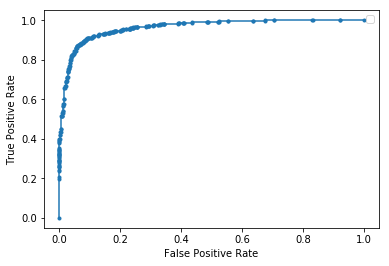

No handles with labels found to put in legend.


Precesion Recall AUC: 0.9671


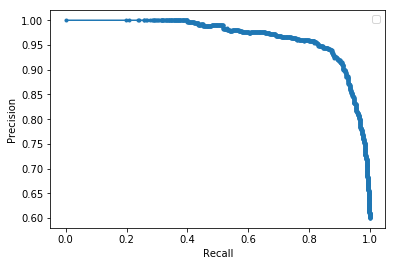

In [27]:
tp = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability) if v >= 0.5])
fn = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability) if v < 0.5])
tn = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability) if v < 0.5])
fp = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability) if v >= 0.5])
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

y_true_test = output_positive_test.loc[output_positive_test.species_id  =='MAD'].label.tolist()+ output_negative_test.loc[output_positive_test.species_id  =='MAD'].label.tolist()
y_predicted_probability_test = output_positive_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability.tolist() + output_negative_test.loc[output_positive_test.species_id  =='MAD'].predicted_probability.tolist()
AUC = roc_auc_score(y_true_test, y_predicted_probability_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

fpr, tpr, thresholds = roc_curve(y_true_test, y_predicted_probability_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true_test, y_predicted_probability_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Evaluation for SRI

Text(0.5, 1.0, 'Predicted Probability - Without SRI Calls')

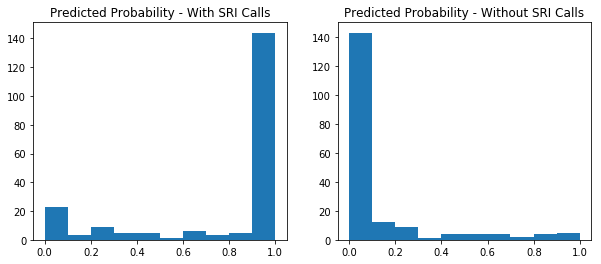

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax = ax.ravel() 

ax[0].hist(output_positive_test.loc[output_positive_test.species_id =='SRI'].predicted_probability)
ax[0].set_title('Predicted Probability - With SRI Calls')

ax[1].hist(output_negative_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability)
ax[1].set_title('Predicted Probability - Without SRI Calls')


No handles with labels found to put in legend.


False Negative Rate: 22.06%
False Positive Rate: 10.11%
AUC: 0.9358
Accuracy: 0.8367
Precision: 0.8933
Recall: 0.7794


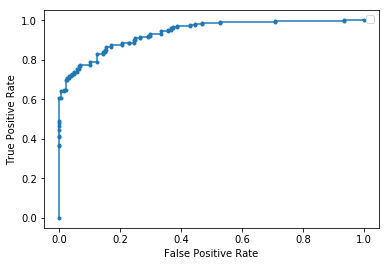

No handles with labels found to put in legend.


Precesion Recall AUC: 0.9489


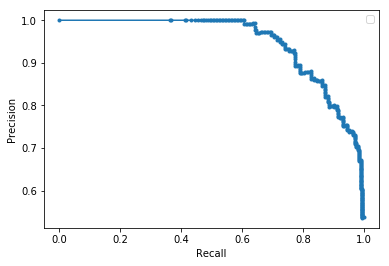

In [29]:
tp = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability) if v >= 0.5])
fn = len([i for i,v in enumerate(output_positive_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability) if v < 0.5])
tn = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability) if v < 0.5])
fp = len([i for i,v in enumerate(output_negative_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability) if v >= 0.5])
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

y_true_test = output_positive_test.loc[output_positive_test.species_id  =='SRI'].label.tolist()+ output_negative_test.loc[output_positive_test.species_id  =='SRI'].label.tolist()
y_predicted_probability_test = output_positive_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability.tolist() + output_negative_test.loc[output_positive_test.species_id  =='SRI'].predicted_probability.tolist()
AUC = roc_auc_score(y_true_test, y_predicted_probability_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

fpr, tpr, thresholds = roc_curve(y_true_test, y_predicted_probability_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true_test, y_predicted_probability_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [32]:
output_positive_test_all_species = pd.DataFrame()
output_positive_test_all_species['filename'] = directory_filenames_Positive_test
for i in range(len(output_positive_test_all_species)):
    species_id = output_positive_test_all_species.loc[i, 'filename'].split('\\')[-1].split('_')[0]
    output_positive_test_all_species.at[i, 'species_id'] = species_id
output_positive_test_all_species['ANT_prob'] = yhat_Positive_test_probs_ANT
output_positive_test_all_species['AUS_prob'] = yhat_Positive_test_probs_AUS
output_positive_test_all_species['MAD_prob'] = yhat_Positive_test_probs_MAD
output_positive_test_all_species['SRI_prob'] = yhat_Positive_test_probs_SRI


In [33]:
yhat_probs_Positive_test = model.predict(X_test_Positive)

In [34]:
pred_positive_test = pd.DataFrame()
pred_positive_test['spectrogram_filename'] = directory_filenames_Positive_test
pred_positive_test['true_species_id'] = ''
pred_positive_test['pred_species_id'] = ''
for i in range(len(pred_positive_test)):
    species_id_positive_index = list(y_test_Positive[i]).index(1)
    pred_positive_test.at[i, 'true_species_id'] = list(species_id_class_dict.keys())[list(species_id_class_dict.values()).index(species_id_positive_index)]
    pred_species_id_index = list(yhat_probs_Positive_test[i]).index(max(yhat_probs_Positive_test[i]))
    if max(yhat_probs_Positive_test[i]) >= 0.5:
        pred_positive_test.at[i, 'pred_species_id'] = list(species_id_class_dict.keys())[list(species_id_class_dict.values()).index(pred_species_id_index)]
    else:
        pred_positive_test.at[i, 'pred_species_id'] = 'Negative'
        

In [35]:
confusion_matrix = pd.crosstab(pred_positive_test['true_species_id'], pred_positive_test['pred_species_id'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  ANT  AUS  MAD  Negative  SRI
Actual                                 
ANT        421    0    0        47    0
AUS          0  398    2        33    1
MAD          0    0  704        73    1
SRI          0    7    0        38  159
